In [4]:
import torch
import torch.nn as nn
from datasets import load_dataset
from collections import Counter
import random
import numpy as np
from torch.utils.data import DataLoader, Dataset



In [7]:
!pip install -U datasets fsspec


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [1]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
from datasets import load_dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
text_data = dataset["train"]["text"]
text_data = text_data[:2000]  # Use first 2000 lines




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [5]:
# Flatten and tokenize
tokens = ' '.join(text_data).lower().split()
counter = Counter(tokens)
vocab = {word: i for i, (word, _) in enumerate(counter.items())}
inv_vocab = {i: word for word, i in vocab.items()}
vocab_size = len(vocab)
print(vocab)
len(vocab)


{'=': 0, 'valkyria': 1, 'chronicles': 2, 'iii': 3, 'senjō': 4, 'no': 5, '3': 6, ':': 7, 'unrecorded': 8, '(': 9, 'japanese': 10, '戦場のヴァルキュリア3': 11, ',': 12, 'lit': 13, '.': 14, 'of': 15, 'the': 16, 'battlefield': 17, ')': 18, 'commonly': 19, 'referred': 20, 'to': 21, 'as': 22, 'outside': 23, 'japan': 24, 'is': 25, 'a': 26, 'tactical': 27, 'role': 28, '@-@': 29, 'playing': 30, 'video': 31, 'game': 32, 'developed': 33, 'by': 34, 'sega': 35, 'and': 36, 'media.vision': 37, 'for': 38, 'playstation': 39, 'portable': 40, 'released': 41, 'in': 42, 'january': 43, '2011': 44, 'it': 45, 'third': 46, 'series': 47, 'employing': 48, 'same': 49, 'fusion': 50, 'real': 51, 'time': 52, 'gameplay': 53, 'its': 54, 'predecessors': 55, 'story': 56, 'runs': 57, 'parallel': 58, 'first': 59, 'follows': 60, '"': 61, 'nameless': 62, 'penal': 63, 'military': 64, 'unit': 65, 'serving': 66, 'nation': 67, 'gallia': 68, 'during': 69, 'second': 70, 'europan': 71, 'war': 72, 'who': 73, 'perform': 74, 'secret': 75, 'bla

12729

In [6]:
#extract sentence from data
for line in text_data:
    print(line)



 = Valkyria Chronicles III = 


 Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . 

 The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series 

In [7]:
sequence_length = 5

sequences = []
targets = []

for i in range(len(tokens) - sequence_length):
    seq = tokens[i:i + sequence_length]
    target = tokens[i + sequence_length]
    if all(word in vocab for word in seq + [target]):
        sequences.append([vocab[word] for word in seq])
        targets.append(vocab[target])

X = torch.tensor(sequences)
y = torch.tensor(targets)


In [8]:
class WordDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = WordDataset(X, y)
loader = DataLoader(dataset, batch_size=128, shuffle=True)


In [9]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # last time step
        return out

model = RNNModel(vocab_size, embed_dim=64, hidden_dim=128)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

epochs = 5
loss_per_epoch = []
for epoch in range(epochs):
    total_loss = 0
    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    loss_per_epoch.append(total_loss)



Epoch 1, Loss: 6095.4207
Epoch 2, Loss: 5164.0307
Epoch 3, Loss: 4486.3817
Epoch 4, Loss: 3875.0873
Epoch 5, Loss: 3349.9686


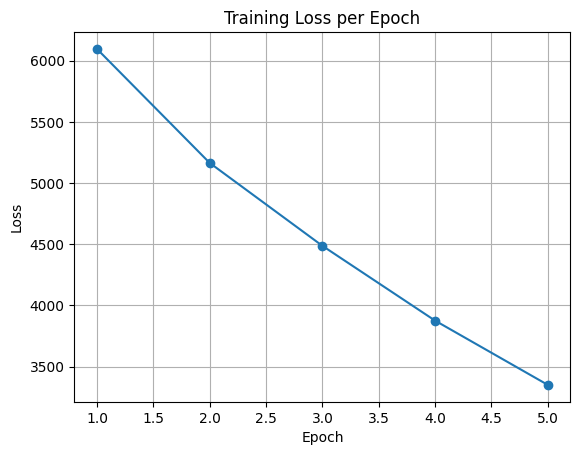

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), loss_per_epoch, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [15]:
def predict_next(model, seed_text, vocab, inv_vocab, sequence_length=5):
    model.eval()
    words = seed_text.lower().split()
    if len(words) < sequence_length:
        words = ['<pad>'] * (sequence_length - len(words)) + words
    idx_seq = [vocab.get(word, 0) for word in words[-sequence_length:]]
    input_seq = torch.tensor([idx_seq])
    with torch.no_grad():
        out = model(input_seq)
        pred_idx = torch.argmax(out, dim=1).item()
    return inv_vocab.get(pred_idx, "<unk>")

seed = "the meaning of life is"
print("Input:", seed)
print("Predicted next word:", predict_next(model, seed, vocab, inv_vocab))


Input: the meaning of life is
Predicted next word: a


In [13]:
print("predicted next word:",predict_next(model, "The weather is", vocab ,inv_vocab, ))
print("predicted next word:",predict_next(model, "i love to ", vocab ,inv_vocab, ))


predicted next word: a
predicted next word: the


In [14]:
torch.save(model.state_dict(), "rnn_next_word.pt")

# Load later:
# model.load_state_dict(torch.load("rnn_next_word.pt"))
